In [310]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import yfinance as yf
import functions as f


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Prepcocessing

In [311]:
tickerlist = ['BTC-USD']
df = yf.download(tickerlist, period = '1d', start = '2007-01-01',end = pd.Timestamp.today())
columns = tickerlist
df = df.iloc[:,4]['2019':]
df.head()

[*********************100%***********************]  1 of 1 completed


Date
2019-01-01    3843.520020
2019-01-02    3943.409424
2019-01-03    3836.741211
2019-01-04    3857.717529
2019-01-05    3845.194580
Name: Adj Close, dtype: float64

In [312]:
df = pd.DataFrame(df).pct_change().dropna()
df.index = df.index.astype(str)
df['Adj Close'] = df['Adj Close']
df['date'] = df.index
df

,Adj Close,date
Date,,
2019-01-02,0.025989,2019-01-02
2019-01-03,-0.027050,2019-01-03
2019-01-04,0.005467,2019-01-04
2019-01-05,-0.003246,2019-01-05
2019-01-06,0.060189,2019-01-06
...,...,...
2022-04-08,-0.027956,2022-04-08
2022-04-09,0.011693,2022-04-09
2022-04-10,-0.013428,2022-04-10


## Import backtest results generated from Model.ipynb

In [313]:
bt = pd.read_csv('backtest_results.csv',index_col = 0)
bt.index = pd.to_datetime(bt.index).strftime('%Y-%m-%d')
bt['BTC-USD'] = [1 if x == 1 else -1 for x in bt['BTC-USD']]
bt.index = bt.index.astype(str)
bt_returns = bt[['BTC-USD']]
bt_returns['date'] = bt_returns.index
bt_returns = bt_returns.loc['2021-01-01':]

<ipython-input-313-f69c42deeeac>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bt_returns['date'] = bt_returns.index


## The 'BTC-USD' Column indicates whether we the model predicts if btc is going up or down:
1. -1 => BTC going down => Short
2. 1 => BTC going up => Long
3. Transform the returns by multiplying the returns column by 1 or -1 to get te returns of the model
4. Perfrom df.cumprod() function to get the compounded returns

In [314]:
df = df.merge(bt_returns, on = 'date', how = 'right').dropna()

In [315]:
df.set_index('date',inplace = True)
df.columns = ['bitcoin daily returns','predictions']


In [316]:
df.head()

,bitcoin daily returns,predictions
date,,
2021-01-01,0.012842,1
2021-02-01,0.012768,1
2021-03-01,0.099550,1
2021-04-01,0.003004,1
2021-05-01,0.001348,1


In [317]:
df['Passive Hold Strategy'] = df['bitcoin daily returns']
df['NLP Trading Strategy'] = df['bitcoin daily returns'] * df['predictions']
df = df[['Passive Hold Strategy','NLP Trading Strategy']]
df.head()

,Passive Hold Strategy,NLP Trading Strategy
date,,
2021-01-01,0.012842,0.012842
2021-02-01,0.012768,0.012768
2021-03-01,0.099550,0.099550
2021-04-01,0.003004,0.003004
2021-05-01,0.001348,0.001348


In [318]:
returns = 100*((1+df).cumprod())
returns.head()

,Passive Hold Strategy,NLP Trading Strategy
date,,
2021-01-01,101.284171,101.284171
2021-02-01,102.577405,102.577405
2021-03-01,112.789003,112.789003
2021-04-01,113.127791,113.127791
2021-05-01,113.280342,113.280342


## Backtest results from start of 2021 to now

Text(0, 0.5, 'Compounded Returns (%)')

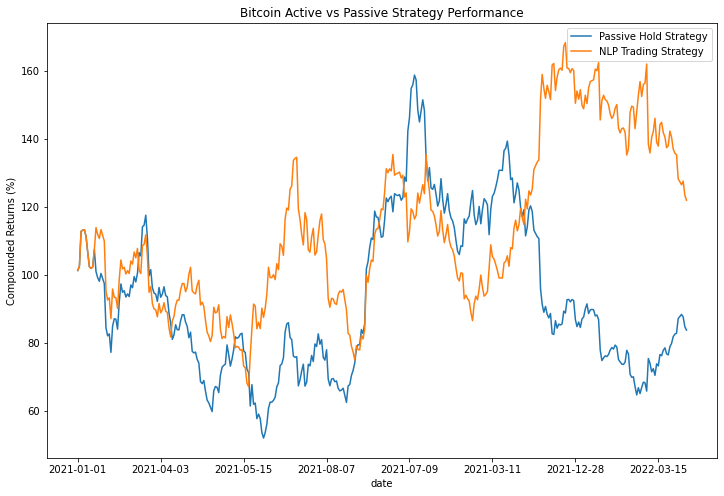

In [319]:
returns.plot(figsize = (12,8), title = 'Bitcoin Active vs Passive Strategy Performance')
plt.ylabel('Compounded Returns (%)')